## Neural network based on backward automatic differentiation

### Iris dataset

Kinds of irises:

    * setosa     = [1.0  0.0  0.0]
    * versicolor = [0.0  1.0  0.0]
    * virginica  = [0.0  0.0  1.0]

#### Import packages

In [1]:
include("data_preparing.jl");

####  Data preparing

In [2]:
iris_dataset = prepare_iris();
train_set, test_set = split_dataset(iris_dataset, 0.8);

### Neural network

#### Import packages

In [3]:
using LinearAlgebra
using PyPlot
include("automatic_differentiation.jl");

#### Design architecture

In [4]:
function dense(w, b, x, activation) return activation.(w * x .+ b) end
function dense(w, x, activation) return activation.(w * x) end
function dense(w, x) return w * x end

function mean_squared_loss(y, ŷ)
    return Constant(1.0/3.0) .* sum.((y .- ŷ) .^ Constant(2))
end

function net(x, Wh, Wo, y)
    x̂ = dense(Wh, x, σ)
    x̂.name = "x̂"
    ŷ = dense(Wo, x̂, softmax)
    ŷ.name = "ŷ"
    E = mean_squared_loss(y, ŷ)
    E.name = "total_loss"
    return topological_sort(E)
end    

net (generic function with 1 method)

In [5]:
function dnet(E)
    forward!(E)
    backward!(E)
    tuple(E[4].gradient, E[3].gradient, E[14].output)
end

dnet (generic function with 1 method)

In [6]:
function optimize!(Wh::Variable, Wo::Variable, dWh::Matrix, dWo::Matrix, α::Float64)
    Wh.output -= α * dWh
    Wo.output -= α * dWo
end

optimize! (generic function with 1 method)

### Learning neural network

#### Batch Gradient Descent

In [7]:
function learn_BGD(x::Variable, Wh::Variable, Wo::Variable, y::Variable, epochs::Int64, α::Float64)
    E = net(x, Wh, Wo, y)
    total_losses = Vector()
    for i=1:epochs
        input_data, expected_values = adjust_dataset(train_set)
        dWh = zeros(length(Wh.output[:,1]), length(Wh.output[1,:]))
        dWo = zeros(length(Wo.output[:,1]), length(Wo.output[1,:]))
        epoch_loss = .0
        for j=1:length(input_data[:,1])
            x.output = input_data[j,:]
            y.output = expected_values[j,:]
            tmp_dWh, tmp_dWo, tmp_loss = dnet(E)
            dWh += tmp_dWh
            dWo += tmp_dWo
            epoch_loss += tmp_loss
        end
        dWh ./= length(input_data[:,1])
        dWo ./= length(input_data[:,1])
        append!(total_losses, epoch_loss/length(input_data[:,1]))
        optimize!(Wh, Wo, dWh, dWo, α)
    end
    tuple(E, total_losses)
end

learn_BGD (generic function with 1 method)

#### Mini-batch Gradient Descent

In [8]:
function learn_MBGD(x::Variable, Wh::Variable, Wo::Variable, y::Variable, epochs::Int64, batch_size::Int64, α::Float64)
    E = net(x, Wh, Wo, y)
    total_losses = Vector()
    last_batch = length(train_set[:,1]) % batch_size
    for i=1:epochs
        input_data, expected_values = adjust_dataset(train_set)
        dWh = zeros(length(Wh.output[:,1]), length(Wh.output[1,:]))
        dWo = zeros(length(Wo.output[:,1]), length(Wo.output[1,:]))
        batch_loss = .0
        for j=1:length(input_data[:,1])
            x.output = input_data[j,:]
            y.output = expected_values[j,:]
            tmp_dWh, tmp_dWo, tmp_loss = dnet(E)
            dWh += tmp_dWh
            dWo += tmp_dWo
            batch_loss += tmp_loss
            if j % batch_size == 0
                append!(total_losses, batch_loss/batch_size)
                batch_loss = .0
                dWh ./= batch_size
                dWo ./= batch_size
                optimize!(Wh, Wo, dWh, dWo, α)
                dWh = zeros(length(Wh.output[:,1]), length(Wh.output[1,:]))
                dWo = zeros(length(Wo.output[:,1]), length(Wo.output[1,:]))
            end
        end
        if length(input_data[:,1]) % batch_size != 0
            append!(total_losses, batch_loss/last_batch)
            dWh ./= last_batch
            dWo ./= last_batch
        end
        optimize!(Wh, Wo, dWh, dWo, α)
    end
    tuple(E, total_losses)
end

learn_MBGD (generic function with 1 method)

#### Stochastic Gradient Descent

In [9]:
function learn_SGD(x::Variable, Wh::Variable, Wo::Variable, y::Variable, epochs::Int64, α::Float64)
    E = net(x, Wh, Wo, y)
    total_losses = Vector()
    for i=1:epochs
        input_data, expected_values = adjust_dataset(train_set)
        epoch_loss = .0
        for j=1:length(input_data[:,1])
            x.output = input_data[j,:]
            y.output = expected_values[j,:]
            dWh, dWo, tmp_loss = dnet(E)
            epoch_loss += tmp_loss
            optimize!(Wh, Wo, dWh, dWo, α)
        end
        append!(total_losses, epoch_loss/length(input_data[:,1]))
    end
    tuple(E, total_losses)
end

learn_SGD (generic function with 1 method)

### Predictioning

In [10]:
function predict_result(E, input)
    E[5].output = input
    forward!(E)
    E[9].output
end

predict_result (generic function with 1 method)

### Model verification

In [11]:
function count_accuracy(E, input_data, expected_values)
    if length(input_data[:,1]) != length(expected_values[:,1]) || length(input_data[:,1]) < 1
        return "Incorrect size of dataset!"
    end
    predicts = zeros(0,3)
    for i=1:length(input_data[:,1])
        p = predict_result(E, input_data[i,:])
        predicts = vcat(predicts, p')
    end
    positive = 0
    negative = 0
    for i=1:length(predicts[:,1])
        if argmax(predicts[i,:]) == argmax(expected_values[i,:])
            positive += 1
        else
            negative += 1
        end
    end
    100.0 * positive / (positive + negative)
end

count_accuracy (generic function with 1 method)

### Building models

#### Batch Gradient Descent

In [12]:
epochs = 1000
α = 0.25

x = Variable(nothing, name="x")
Wh = Variable(rand(10, 4), name="Wh")
Wo = Variable(rand(3, 10), name="Wo")
y = Variable(nothing, name="y")

E, total_losses = learn_BGD(x, Wh, Wo, y, epochs, α);

In [13]:
test_dataset, test_expected_values = adjust_dataset(test_set)
acc = count_accuracy(E, test_dataset, test_expected_values)
println("Test set accuracy =  ", round(acc, digits=2), "%")

train_dataset, train_expected_values = adjust_dataset(train_set)
acc = count_accuracy(E, train_dataset, train_expected_values)
println("Train set accuracy = ", round(acc, digits=2), "%")

Test set accuracy =  100.0%
Train set accuracy = 95.0%


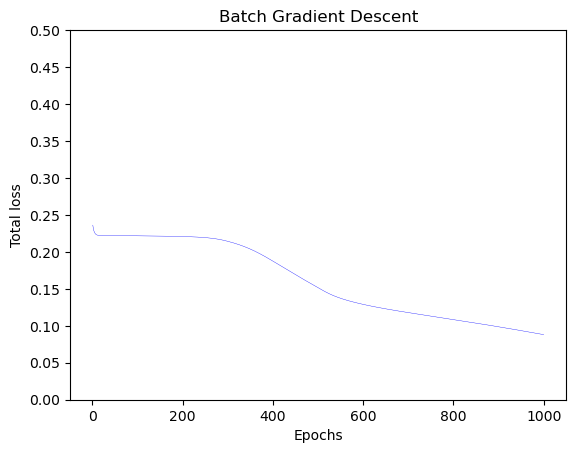

In [14]:
x_ax = 1:epochs
y_ax = total_losses
plot(x_ax, y_ax, color="blue", linewidth=0.25)
PyPlot.yticks(0:0.05:0.5)
title("Batch Gradient Descent")
xlabel("Epochs")
ylabel("Total loss");

#### Mini-batch Gradient Descent

In [15]:
epochs = 300
batch_size = 16
α = 0.15

x = Variable(nothing, name="x")
Wh = Variable(rand(10, 4), name="Wh")
Wo = Variable(rand(3, 10), name="Wo")
y = Variable(nothing, name="y")

E, total_losses = learn_MBGD(x, Wh, Wo, y, epochs, batch_size, α);

In [16]:
test_dataset, test_expected_values = adjust_dataset(test_set)
acc = count_accuracy(E, test_dataset, test_expected_values)
println("Test set accuracy =  ", round(acc, digits=2), "%")

train_dataset, train_expected_values = adjust_dataset(train_set)
acc = count_accuracy(E, train_dataset, train_expected_values)
println("Train set accuracy = ", round(acc, digits=2), "%")

Test set accuracy =  93.33%
Train set accuracy = 90.0%


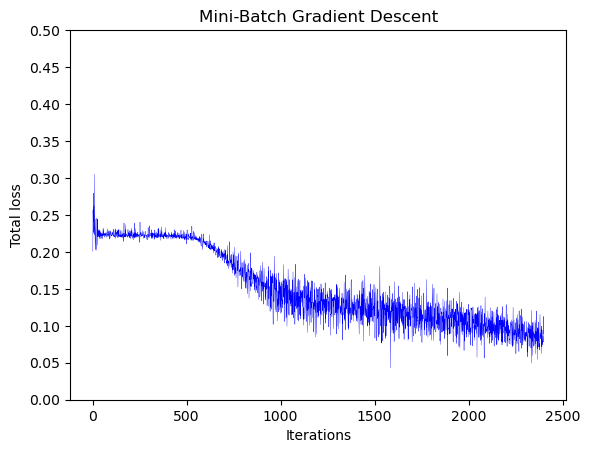

In [17]:
x_ax = 1:epochs * round(length(train_set[:,1])/batch_size)
y_ax = total_losses
plot(x_ax, y_ax, color="blue", linewidth=0.25)
PyPlot.yticks(0:0.05:0.5)
title("Mini-Batch Gradient Descent")
xlabel("Iterations")
ylabel("Total loss");

#### Stochastic Gradient Descent

In [18]:
epochs = 400
α = 0.1

x = Variable(nothing, name="x")
Wh = Variable(rand(10, 4), name="Wh")
Wo = Variable(rand(3, 10), name="Wo")
y = Variable(nothing, name="y")

E, total_losses = learn_SGD(x, Wh, Wo, y, epochs, α);

In [19]:
test_dataset, test_expected_values = adjust_dataset(test_set)
acc = count_accuracy(E, test_dataset, test_expected_values)
println("Test set accuracy =  ", round(acc, digits=2), "%")

train_dataset, train_expected_values = adjust_dataset(train_set)
acc = count_accuracy(E, train_dataset, train_expected_values)
println("Train set accuracy = ", round(acc, digits=2), "%")

Test set accuracy =  93.33%
Train set accuracy = 97.5%


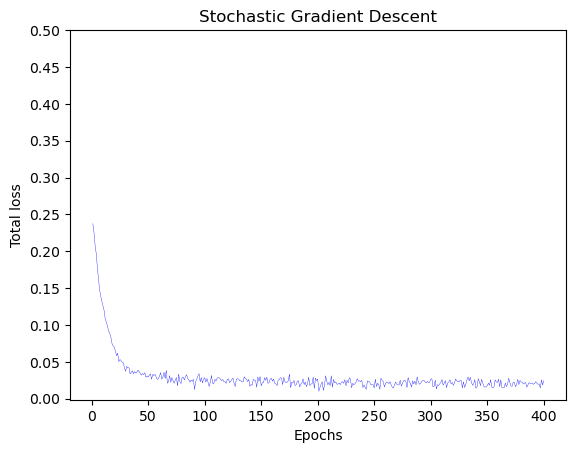

In [20]:
x_ax = 1:epochs
y_ax = total_losses
plot(x_ax, y_ax, color="blue", linewidth=0.25)
PyPlot.yticks(0:0.05:0.5)
title("Stochastic Gradient Descent")
xlabel("Epochs")
ylabel("Total loss");